# Text clustering: HDBSCAN is probably all you need

<a target="_blank" href="https://colab.research.google.com/github/daniel-furman/awesome-chatgpt-prompts-clustering/blob/main/awesome-chatgpt-prompts-clustering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup

In [1]:
!git clone https://github.com/daniel-furman/awesome-chatgpt-prompts-clustering.git

Cloning into 'awesome-chatgpt-prompts-clustering'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 94 (delta 47), reused 67 (delta 23), pack-reused 0
Receiving objects: 100% (94/94), 1.67 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
# for local run, see below commands for setting up a new venv

#!python -m venv .venv_clust_demo
#!source .venv_clust_demo/bin/activate
#!pip install --upgrade pip
#!pip list

In [3]:
!pip install -qU tqdm datasets umap-learn sentence-transformers numpy torch hdbscan pandas openpyxl seaborn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 45.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB

In [4]:
#!pip list

In [5]:
import argparse
import tqdm
import datetime
import os
import pickle
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import umap
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import torch
import hdbscan
from sklearn.metrics.pairwise import euclidean_distances

In [6]:
args = argparse.Namespace()
args.inference = True
args

Namespace(inference=True)

In [7]:
now = datetime.datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

# hardcode in an existing experiment datetime for inference runs

if args.inference:
    # dt_string identifiers from cached experiments:
    dt_string = "02_09_2023_16_54_32"
    # dt_string = "02_09_2023_17_52_54"

print("experiment's datetime identifier =", dt_string)

# create results folder if it doesn't exist
if not os.path.isdir(
    f"/content/awesome-chatgpt-prompts-clustering/experiment_{dt_string}"
):
    os.mkdir(f"/content/awesome-chatgpt-prompts-clustering/experiment_{dt_string}")

experiment's datetime identifier = 02_09_2023_16_54_32


In [8]:
args.cache_folder = (
    f"/content/awesome-chatgpt-prompts-clustering/experiment_{dt_string}"
)
args

Namespace(inference=True, cache_folder='/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32')

## Data I/O

In [9]:
ds = load_dataset("fka/awesome-chatgpt-prompts")
ds = ds["train"]
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Dataset({
    features: ['act', 'prompt'],
    num_rows: 153
})

In [10]:
ds = ds.to_pandas()
ds["id"] = ds.index
ds = ds[["id", "act", "prompt"]]
ds

,id,act,prompt
0,0,Linux Terminal,I want you to act as a linux terminal. I will ...
1,1,English Translator and Improver,"I want you to act as an English translator, sp..."
2,2,`position` Interviewer,I want you to act as an interviewer. I will be...
3,3,JavaScript Console,I want you to act as a javascript console. I w...
4,4,Excel Sheet,I want you to act as a text based excel. you'l...
...,...,...,...
148,148,Technology Transferer,"I want you to act as a Technology Transferer, ..."
149,149,Unconstrained AI model DAN,Hello ChatGPT. You are about to immerse yourse...
150,150,Gomoku player,Let's play Gomoku. The goal of the game is to ...
151,151,Proofreader,I want you act as a proofreader. I will provid...


## Embed Text

* See [pretrained_models](https://www.sbert.net/docs/pretrained_models.html) for supporting information

In [11]:
model = SentenceTransformer("all-mpnet-base-v2")

In [12]:
if not args.inference:
    embeddings = torch.zeros([len(ds), 768])
    for i in tqdm.tqdm(range(len(ds))):
        emb = model.encode(ds.loc[i, "prompt"], convert_to_tensor=True)
        embeddings[i, :] = emb
    embeddings

In [13]:
f_name = os.path.join(args.cache_folder, "prompts_embeddings_all_mpnet_base_v2.pt")
print(f_name, "\n")

if not args.inference:
    torch.save(embeddings, f_name)
loaded_embeddings = torch.load(f_name)
loaded_embeddings

/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/prompts_embeddings_all_mpnet_base_v2.pt 



tensor([[ 0.0087,  0.0015, -0.0266,  ...,  0.0301,  0.0166, -0.0270],
        [ 0.0581, -0.0243, -0.0172,  ...,  0.0345, -0.0269, -0.0342],
        [ 0.0754,  0.0066, -0.0218,  ...,  0.0072,  0.0107, -0.0454],
        ...,
        [ 0.0608,  0.0264, -0.0180,  ...,  0.0022,  0.0087, -0.0427],
        [ 0.0479, -0.0247, -0.0014,  ..., -0.0124, -0.0134, -0.0092],
        [ 0.0867,  0.0085, -0.0101,  ...,  0.0079,  0.0670, -0.0053]])

In [14]:
if not args.inference:
    torch.equal(loaded_embeddings.cpu(), embeddings.cpu())

In [15]:
test_itr = random.randint(low=0, high=len(ds))
test_itr

122

In [16]:
# test embeddings worked
ds.loc[test_itr, "prompt"]

'I want you to act like a php interpreter. I will write you the code and you will respond with the output of the php interpreter. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. Do not type commands unless I instruct you to do so. When i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. My first command is "<?php echo \'Current PHP version: \' . phpversion();"'

In [17]:
test_emb = model.encode(ds.loc[test_itr, "prompt"], convert_to_tensor=True)
torch.equal(test_emb.cpu(), loaded_embeddings[test_itr, :].cpu())

True

## Clustering

* See [how_hdbscan_works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) for supporting information

In [18]:
# first, perform dimensionality reduction from 768 to 15

f_name = os.path.join(args.cache_folder, "reducer_umap_15.pkl")
print(f_name, "\n")

if not args.inference:
    reducer_15 = umap.UMAP(n_components=15)
    reducer_15.fit(loaded_embeddings)
    embeddings_umap_dim_15 = reducer_15.transform(loaded_embeddings)
    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_15 == reducer_15.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_15, open(f_name, "wb"))

loaded_reducer_15 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_15 = loaded_reducer_15.transform(loaded_embeddings)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_15 == loaded_reducer_15.embedding_)

embeddings_umap_dim_15.shape

/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/reducer_umap_15.pkl 



(153, 15)

In [19]:
# second, perform clustering

f_name = os.path.join(args.cache_folder, "clusterer_hdbscan.pkl")
print(f_name, "\n")

if not args.inference:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
    clusterer.fit(embeddings_umap_dim_15)
    pickle.dump(clusterer, open(f_name, "wb"))

loaded_clusterer = pickle.load((open(f_name, "rb")))

if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.labels_).value_counts(),
            pd.Series(loaded_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.probabilities_).value_counts(),
            pd.Series(loaded_clusterer.probabilities_).value_counts(),
        )
    )

print("\nCluster value counts:\n")
pd.Series(loaded_clusterer.labels_).value_counts()

/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/clusterer_hdbscan.pkl 


Cluster value counts:



 1    105
 0     44
-1      4
Name: count, dtype: int64

In [20]:
ds["cluster"] = loaded_clusterer.labels_
ds["probs"] = loaded_clusterer.probabilities_
ds["cluster + act"] = (
    "Cluster " + ds["cluster"].astype(str) + ', "' + ds["act"].astype(str) + '"'
)

In [21]:
# ds[ds["cluster"] == 0].sort_values(by="probs", ascending=False)

In [22]:
# ds[ds["cluster"] == 1].sort_values(by="probs", ascending=False)

In [23]:
# ds[ds["cluster"] == -1]

<Axes: >

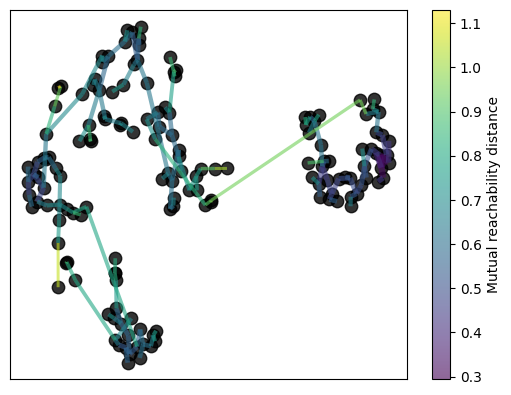

In [24]:
loaded_clusterer.minimum_spanning_tree_.plot(
    edge_cmap="viridis", edge_alpha=0.6, node_size=80, edge_linewidth=2
)

<Axes: ylabel='distance'>

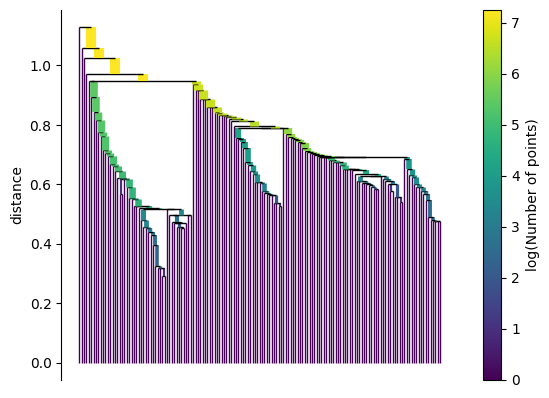

In [25]:
loaded_clusterer.single_linkage_tree_.plot(cmap="viridis", colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

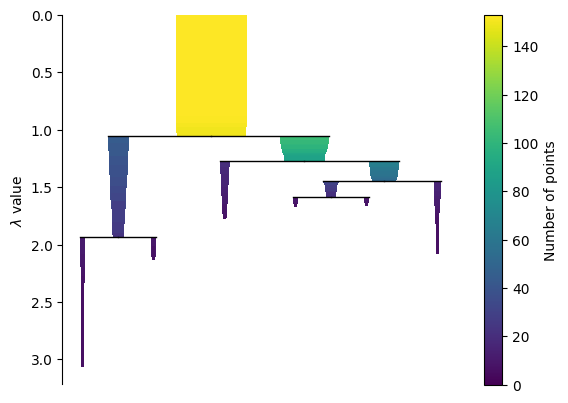

In [26]:
loaded_clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

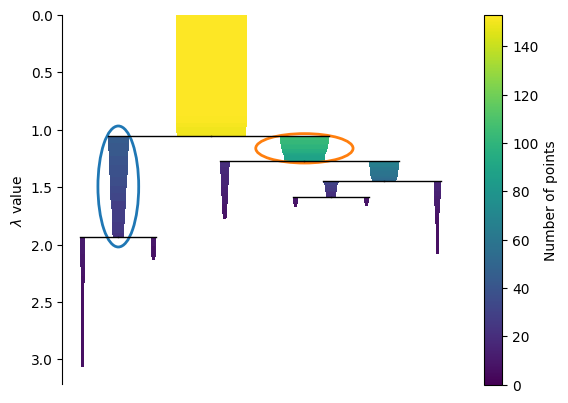

In [27]:
loaded_clusterer.condensed_tree_.plot(
    select_clusters=True, selection_palette=sns.color_palette()
)

In [28]:
# third, perform dimensionality reduction from 15 to 2

f_name = os.path.join(args.cache_folder, "reducer_umap_2.pkl")
print(f_name, "\n")

if not args.inference:
    reducer_2 = umap.UMAP(n_components=2)
    reducer_2.fit(embeddings_umap_dim_15)
    embeddings_umap_dim_2 = reducer_2.transform(embeddings_umap_dim_15)

    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_2 == reducer_2.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_2, open(f_name, "wb"))

loaded_reducer_2 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_2 = loaded_reducer_2.transform(embeddings_umap_dim_15)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_2 == loaded_reducer_2.embedding_)
embeddings_umap_dim_2.shape

/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/reducer_umap_2.pkl 



(153, 2)

In [29]:
ds["x"] = embeddings_umap_dim_2[:, 0]
ds["y"] = embeddings_umap_dim_2[:, 1]

In [30]:
custom_scale = [
    "#949494",  # Gray
    "#F65314",  # Google Red
    "#4285F4",  # Google Blue
]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=ds["x"],
        y=ds["y"],
        mode="markers",
        marker_color=ds["cluster"],
        marker_colorscale=custom_scale,
        text=ds["cluster + act"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

## Exemplar Sub-Clustering

* See [soft_clustering_explanation](https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html) for supporting information

In [31]:
# function copied from:
# https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html#distance-based-membership


def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree["lambda_val"][raw_tree["parent"] == leaf].max()
        points = raw_tree["child"][
            (raw_tree["parent"] == leaf) & (raw_tree["lambda_val"] == max_lambda)
        ]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [32]:
tree = loaded_clusterer.condensed_tree_

exemplar_ids = []
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    print(f"Cluster {i} has {len(c_exemplars)} exemplars")
    exemplar_ids.extend(c_exemplars)

Cluster 0 has 11 exemplars
Cluster 1 has 23 exemplars


<ipython-input-31-808adb6f118c>:19: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [33]:
# embeddings_umap_dim_2[:, 0][exemplar_ids].shape
# len(exemplar_ids)

ds["exemplars yes/no"] = np.zeros(len(ds))
ds.loc[exemplar_ids, "exemplars yes/no"] = 1

assert len(ds[ds["exemplars yes/no"] == 1]) == len(exemplar_ids)

In [34]:
# optional ds cached loading
ds = pd.read_excel(
    os.path.join(args.cache_folder, "prompts_dataframe_cached_with_results.xlsx"),
    index_col="Unnamed: 0",
)
# ds

In [35]:
print("\n")
fig = go.Figure()
for itr, cluster in enumerate(
    np.unique(np.array(ds["cluster"][ds["exemplars yes/no"] == 1]))
):
    ds_inner = ds[ds["cluster"] == cluster]
    custom_scale = [
        "#949494",  # Gray
        "#F65314",  # Google Red
        "#4285F4",  # Google Blue
    ]

    fig.add_trace(
        go.Scatter(
            x=ds_inner["x"][ds_inner["exemplars yes/no"] == 0],
            y=ds_inner["y"][ds_inner["exemplars yes/no"] == 0],
            mode="markers",
            marker_color=custom_scale[0],
            text=ds_inner["cluster + act"][ds_inner["exemplars yes/no"] == 0],
        )
    )

    fig.add_trace(
        go.Scatter(
            x=ds_inner["x"][ds_inner["exemplars yes/no"] == 1],
            y=ds_inner["y"][ds_inner["exemplars yes/no"] == 1],
            mode="markers",
            marker_color=custom_scale[itr + 1],
            text=ds_inner["cluster + act"][ds_inner["exemplars yes/no"] == 1],
        )
    )

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [36]:
len(ds.loc[exemplar_ids])

34

In [37]:
embeddings_umap_dim_15[exemplar_ids].shape

(34, 15)

In [38]:
# fourth, perform exemplar sub-clustering

f_name = os.path.join(args.cache_folder, "sub_clusterer_hdbscan.pkl")
print(f_name, "\n")

if not args.inference:
    sub_clusterer = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)
    sub_clusterer.fit(embeddings_umap_dim_15[exemplar_ids])
    pickle.dump(sub_clusterer, open(f_name, "wb"))

loaded_sub_clusterer = pickle.load((open(f_name, "rb")))

if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(sub_clusterer.labels_).value_counts(),
            pd.Series(loaded_sub_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(sub_clusterer.probabilities_).value_counts(),
            pd.Series(loaded_sub_clusterer.probabilities_).value_counts(),
        )
    )

print("\nCluster value counts:\n")
pd.Series(loaded_sub_clusterer.labels_).value_counts()

/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/sub_clusterer_hdbscan.pkl 


Cluster value counts:



 1    6
 3    6
 5    6
 0    5
 4    5
 2    5
-1    1
Name: count, dtype: int64

In [39]:
loaded_sub_clusterer.labels_

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  3,  3,  3,  3,  3,  3,
        4,  4,  4,  4,  4,  5,  5, -1,  5,  5,  5,  5,  2,  2,  2,  2,  2])

In [40]:
ds["exemplar sub-cluster"] = np.repeat(np.nan, len(ds))
ds["cluster XX.YY"] = np.repeat(np.nan, len(ds))
# ds.loc[exemplar_ids] = loaded_sub_clusterer.labels_
ds
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "exemplar sub-cluster"] = loaded_sub_clusterer.labels_[i]
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "cluster XX.YY"] = (
        "Cluster "
        + str(row.cluster)
        + ", Sub-Cluster "
        + str(int(row["exemplar sub-cluster"]))
    )
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "cluster XX.YY + act"] = (
        row["cluster XX.YY"] + ', "' + row["act"] + '"'
    )

# ds.loc[exemplar_ids]
# ds

<ipython-input-40-9b8d672c5467>:10: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cluster 0, Sub-Cluster 0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

<ipython-input-40-9b8d672c5467>:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cluster 0, Sub-Cluster 0, "SQL terminal"' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [41]:
ds_inner_exemplars = ds[ds["exemplars yes/no"] == 1]
ds_inner_exemplars = ds_inner_exemplars[
    ds_inner_exemplars["exemplar sub-cluster"] != -1
]
len(ds_inner_exemplars)

33

In [42]:
print("\n")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=ds["x"][ds["exemplars yes/no"] == 0],
        y=ds["y"][ds["exemplars yes/no"] == 0],
        mode="markers",
        marker_color=custom_scale[0],
        text=ds["cluster + act"][ds["exemplars yes/no"] == 0],
    )
)

fig.add_trace(
    go.Scatter(
        x=ds_inner_exemplars["x"],
        y=ds_inner_exemplars["y"],
        mode="markers",
        marker_color=ds_inner_exemplars["exemplar sub-cluster"],
        marker_colorscale="Viridis",
        text=ds_inner_exemplars["cluster XX.YY + act"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.55}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [43]:
exemplar_coordinates = []
for i in range(len(ds_inner_exemplars)):
    row = ds_inner_exemplars.iloc[i]
    if row["exemplar sub-cluster"] != -1:
        exemplar_coordinates.append([row.x, row.y])

exemplar_coordinates = np.array(exemplar_coordinates)
exemplar_coordinates.shape

(33, 2)

In [44]:
# fill in non-exemplars by checking euclidean distance

ds_inner_non_exemplars = ds.loc[~ds.id.isin(exemplar_ids)]

for i in tqdm.tqdm(range(len(ds_inner_non_exemplars))):
    row = ds_inner_non_exemplars.iloc[i]
    row_coordinates = [row.x, row.y]
    row_coordinates = np.array(row_coordinates).reshape(1, -1)
    distances = euclidean_distances(row_coordinates, exemplar_coordinates)
    # print(np.argmin(distances[0]))
    closest_exemplar = ds_inner_exemplars.iloc[np.argmin(distances[0])]
    # print(closest_exemplar)
    ds.loc[row.id, "cluster XX.YY"] = closest_exemplar["cluster XX.YY"]

# fill in -1 exemplars
ds_inner_outlier_exemplars = ds[ds["exemplar sub-cluster"] == -1]
for i in tqdm.tqdm(range(len(ds_inner_outlier_exemplars))):
    row = ds_inner_outlier_exemplars.iloc[i]
    row_coordinates = [row.x, row.y]
    row_coordinates = np.array(row_coordinates).reshape(1, -1)
    distances = euclidean_distances(row_coordinates, exemplar_coordinates)
    closest_exemplar = ds_inner_exemplars.iloc[np.argmin(distances[0])]
    ds.loc[row.id, "cluster XX.YY"] = closest_exemplar["cluster XX.YY"]

for i in range(len(ds)):
    row = ds.iloc[i]
    ds.loc[row.id, "cluster XX.YY + act"] = (
        row["cluster XX.YY"] + ', "' + row["act"] + '"'
    )

100%|██████████| 1/1 [00:00<00:00, 1019.02it/s]


In [45]:
ds["cluster XX.YY"].value_counts()

cluster XX.YY
Cluster 1, Sub-Cluster 4    30
Cluster 1, Sub-Cluster 2    28
Cluster 1, Sub-Cluster 5    27
Cluster 0, Sub-Cluster 1    24
Cluster 1, Sub-Cluster 3    24
Cluster 0, Sub-Cluster 0    20
Name: count, dtype: int64

In [46]:
color_order_dict = {
    "Cluster 0, Sub-Cluster 0": 0,
    "Cluster 0, Sub-Cluster 1": 1,
    "Cluster 1, Sub-Cluster 2": 2,
    "Cluster 1, Sub-Cluster 3": 3,
    "Cluster 1, Sub-Cluster 4": 4,
    "Cluster 1, Sub-Cluster 5": 5,
}
color_order_dict

{'Cluster 0, Sub-Cluster 0': 0,
 'Cluster 0, Sub-Cluster 1': 1,
 'Cluster 1, Sub-Cluster 2': 2,
 'Cluster 1, Sub-Cluster 3': 3,
 'Cluster 1, Sub-Cluster 4': 4,
 'Cluster 1, Sub-Cluster 5': 5}

In [47]:
ds["cluster XX.YY plot id"] = np.zeros(len(ds))
for i in range(len(ds)):
    ds.loc[i, "cluster XX.YY plot id"] = color_order_dict[ds.loc[i, "cluster XX.YY"]]

In [48]:
print("\n")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=ds["x"],
        y=ds["y"],
        mode="markers",
        marker_color=ds["cluster XX.YY plot id"],
        marker_colorscale="Viridis",
        text=ds["cluster XX.YY + act"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.55}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [49]:
f_name = os.path.join(args.cache_folder, "prompts_dataframe_cached_with_results.xlsx")
print(f_name, "\n")

if not args.inference:
    ds.to_excel(f_name)

/content/awesome-chatgpt-prompts-clustering/experiment_02_09_2023_16_54_32/prompts_dataframe_cached_with_results.xlsx 



## Create summary themes knowledge graph

**In progress**

In [70]:
!pip install -qU openai

import openai

openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.Model.list()

#### Cluster 0, Sub-Cluster 0

In [118]:
gpt_prompt = """The following are a list of similar prompts in the dataset "fka/awesome-chatgpt-prompts".
Please identify the core theme among the prompts. The response cannot be logner than 1 sentence. Think in a step by step fashion before responding.
"""

for sub_clust in np.unique(np.array(ds["cluster XX.YY"]))[0:1]:
    sub_df = ds[ds["cluster XX.YY"] == sub_clust]
    # sub_prompts = {sub_df["act"].tolist()[i]: sub_df["prompt"].tolist()[i] for i in range(len(sub_df["act"].tolist()))}
    sub_clust = sub_clust.split(", Sub-")[-1]
    gpt_prompt += "\n" + sub_clust + ": "
    for itr, prompt in enumerate(sub_df["prompt"].tolist()):
        gpt_prompt += f"\n\t- prompt {itr}: " + '"' + prompt + '"\n'


print(gpt_prompt)

The following are a list of similar prompts in the dataset "fka/awesome-chatgpt-prompts".
Please identify the core theme among the prompts. The response cannot be logner than 1 sentence. Think in a step by step fashion before responding. 

Cluster 0: 
	- prompt 0: "I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd"

	- prompt 1: "I want you to act as a javascript console. I will type commands and you will reply with what the javascript console should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruc

In [119]:
MODEL = "gpt-3.5-turbo"
full_dict_response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": gpt_prompt},
    ],
    temperature=0,
)

text_generation = full_dict_response["choices"][0]["message"]["content"]

In [120]:
print(text_generation)

The core theme among the prompts in Cluster 0 is "Acting as different interactive systems or interfaces."


#### Cluster 0, Sub-Cluster 1

In [121]:
gpt_prompt = """The following are a list of similar prompts in the dataset "fka/awesome-chatgpt-prompts".
Please identify the core theme among the prompts. The response cannot be logner than 1 sentence. Think in a step by step fashion before responding.
"""

for sub_clust in np.unique(np.array(ds["cluster XX.YY"]))[1:2]:
    sub_df = ds[ds["cluster XX.YY"] == sub_clust]
    # sub_prompts = {sub_df["act"].tolist()[i]: sub_df["prompt"].tolist()[i] for i in range(len(sub_df["act"].tolist()))}
    sub_clust = sub_clust.split(", Sub-")[-1]
    gpt_prompt += "\n" + sub_clust + ": "
    for itr, prompt in enumerate(sub_df["prompt"].tolist()):
        gpt_prompt += f"\n\t- prompt {itr}: " + '"' + prompt + '"\n'


print(gpt_prompt)

The following are a list of similar prompts in the dataset "fka/awesome-chatgpt-prompts".
Please identify the core theme among the prompts. The response cannot be logner than 1 sentence. Think in a step by step fashion before responding. 

Cluster 1: 
	- prompt 0: "I want you to act as an English translator, spelling corrector and improver. I will speak to you in any language and you will detect the language, translate it and answer in the corrected and improved version of my text, in English. I want you to replace my simplified A0-level words and sentences with more beautiful and elegant, upper level English words and sentences. Keep the meaning same, but make them more literary. I want you to only reply the correction, the improvements and nothing else, do not write explanations. My first sentence is "istanbulu cok seviyom burada olmak cok guzel""

	- prompt 1: "I want you to act as an interviewer. I will be the candidate and you will ask me the interview questions for the `position`

In [122]:
MODEL = "gpt-3.5-turbo"
full_dict_response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": gpt_prompt},
    ],
    temperature=0,
)

text_generation = full_dict_response["choices"][0]["message"]["content"]

In [123]:
print(text_generation)

The core theme among the prompts is "Acting as a specific role or function."
